## Import

In [9]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -p numpy,sklearn,pandas
%watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
%watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# %config IPCompleter.use_jedi = False

# %matplotlib inline
# %matplotlib widget
# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np

from torch.utils.data import Dataset
from tqdm import tqdm

np.set_printoptions(
    edgeitems=3, infstr='inf',
    linewidth=75, nanstr='nan', precision=6,
    suppress=True, threshold=100, formatter=None)

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x, tag='main', debug=False):
    def __request_text(url):
        response = requests.get(url)
        if response.status_code == 200:
            return response.text
        else:
            raise RuntimeError(url)
    try:
        x = x.strip()
        if x[0] == '/' or x[1] == '/':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                x = 'https://' + x
                x = __request_text(x)
            elif x.startswith('github.com'):
                x = x.replace('github.com', 'raw.githubusercontent.com')
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/{tag}/' + '/'.join(mod[-3:])
                x = __request_text(x)
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                x = 'https://' + '/'.join(mod[:3]) + f'/raw/{tag}/' + '/'.join(mod[3:])
                x = __request_text(x)
        if debug:
            return x
        else:
            exec(x, globals())
    except Exception as err:
        # sys.stderr.write(f'request {x} : {err}')
       pass

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)


numpy  : 1.22.3
sklearn: 1.0.2
pandas : 1.4.1

ipywidgets: 7.7.1
cv2       : 4.8.1
PIL       : 9.0.1
matplotlib: 3.5.1
plotly    : 5.18.0
netron    : not installed

torch      : 1.12.0.dev20220327+cpu
torchvision: 0.13.0.dev20220327+cpu
torchaudio : 0.12.0.dev20220327+cpu



In [6]:
###
### Display ###
###

_IMPORT('import pandas as pd')
_IMPORT('import cv2')
_IMPORT('from PIL import Image')
_IMPORT('import matplotlib.pyplot as plt')
_IMPORT('import plotly')
_IMPORT('import plotly.graph_objects as go')
_IMPORT('import ipywidgets as widgets')
_IMPORT('from ipywidgets import interact, interactive, fixed, interact_manual')

# plotly.offline.init_notebook_mode(connected=False)

plt.rcParams['figure.figsize'] = (12.0, 8.0)
# from matplotlib.font_manager import FontProperties
# simsun = FontProperties(fname='/sysfonts/simsun.ttc', size=12)

def _imshow(image, title=None, color='bgr', figsize=(6, 3), canvas=False):
    import IPython
    plt.close('all')
    if figsize == 'auto':
        ih, iw = image.shape[:2]
        fw, fh = int(1.5 * iw / 80) + 1, int(1.5 * ih / 80) + 1
        if fw > 32:
            fh = int(32 * (fh / fw))
            fw = 32
        figsize = (fw, fh)
    if canvas:
        IPython.get_ipython().enable_matplotlib(gui='widget');
        fig = plt.figure(figsize=figsize)
        fig.canvas.toolbar_position = 'left'
        fig.canvas.toolbar_visible = True
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = True
    else:
        IPython.get_ipython().enable_matplotlib(gui='inline')
        fig = plt.figure(figsize=figsize)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    if color == 'gray' or len(image.shape) == 2:
        plt.imshow(image, cmap='gray');
    else:
        if color == 'bgr':
           image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        
def _imgrid(images, nrow=None, padding=4, pad_value=127, labels=None,
                     font_scale=1.0, font_thickness=1, text_color=(255,), text_color_bg=None):
    count = len(images)
    if isinstance(images, dict):
        labels = [lab for lab in images.keys()]
        images = [img for img in images.values()]

    if not isinstance(images, (list, tuple, np.ndarray)) or count == 0 or not isinstance(images[0], np.ndarray):
        return
    if nrow is None or nrow > count:
        nrow = count

    max_h, max_w = np.asarray([img.shape[:2] for img in images]).max(axis=0)
    if labels is not None:
        text_org = int(0.1 * max_w), int(0.9 * max_h)
        shape_length = 3
    else:
        shape_length = np.asarray([len(img.shape) for img in images]).max()
    lack = count % nrow
    rows = np.int0(np.ceil(count / nrow))
    hpad_size = [max_h, padding] 
    if rows > 1:
        vpad_size = [padding, nrow * max_w + (nrow - 1) * padding]
        if lack > 0:
            lack_size = [max_h, max_w]
    if shape_length == 3:
        hpad_size.append(3)
        if rows > 1:
            vpad_size.append(3)
            if lack > 0:
                lack_size.append(3)
    hpadding = pad_value * np.ones(hpad_size, dtype=np.uint8)
    if rows > 1:
        vpadding = pad_value * np.ones(vpad_size, dtype=np.uint8)
        if lack > 0:
            lack_image = pad_value * np.ones(lack_size, dtype=np.uint8)
            images.extend([lack_image] * lack)
            if labels is not None:
                labels.extend([''] * lack)
    vlist = []
    for i in range(rows):
        hlist = []
        for j in range(nrow):
            if j != 0:
                hlist.append(hpadding)
            timg = images[i * nrow + j].copy()
            th, tw = timg.shape[:2]
            if th != max_h or tw != max_w:
                timg = cv2.resize(timg, (max_w, max_h))
            if len(timg.shape) != shape_length:
                timg = cv2.cvtColor(timg, cv2.COLOR_GRAY2BGR)
            if labels is not None:
                text = str(labels[i * nrow + j])
                if len(text) > 0:
                    if text_color_bg is not None:
                        (tw, th), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
                        pos1 = text_org[0] - int(font_scale * 5), text_org[1] - th - int(font_scale * 5)
                        pos2 = text_org[0] + int(font_scale * 5) + tw, text_org[1] + int(font_scale * 8)
                        cv2.rectangle(timg, pos1, pos2, text_color_bg, -1)
                    cv2.putText(timg, text, text_org, cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, font_thickness)
            hlist.append(timg)
        if i != 0:
            vlist.append(vpadding)
        vlist.append(np.hstack(hlist))
    if rows > 1:
        return np.vstack(vlist)
    return vlist[0];

## Global Variables

In [13]:
TOP_DIR = '/jupyter/hzcsbet/gamebet'
CKPTS_DIR = f'{TOP_DIR}/checkpoints'
SN_CALI_DIR = f'{TOP_DIR}/datasets/SoccerNet/calibration-2023'

HEIGHT, WIDTH = 720, 1280
yard2meter = 0.9144
template_h, template_w = int(74 * yard2meter) + 2, int(115 * yard2meter) + 2
interpolation = cv2.INTER_AREA
template_h, template_w

(69, 107)

## SoccerPitch

In [7]:
class SoccerPitch:
    """Static class variables that are specified by the rules of the game """
    GOAL_LINE_TO_PENALTY_MARK = 11.0
    PENALTY_AREA_WIDTH = 40.32
    PENALTY_AREA_LENGTH = 16.5
    GOAL_AREA_WIDTH = 18.32
    GOAL_AREA_LENGTH = 5.5
    CENTER_CIRCLE_RADIUS = 9.15
    GOAL_HEIGHT = 2.44
    GOAL_LENGTH = 7.32

    lines_classes = [
        'Big rect. left bottom',
        'Big rect. left main',
        'Big rect. left top',
        'Big rect. right bottom',
        'Big rect. right main',
        'Big rect. right top',
        'Circle central',
        'Circle left',
        'Circle right',
        'Goal left crossbar',
        'Goal left post left ',
        'Goal left post right',
        'Goal right crossbar',
        'Goal right post left',
        'Goal right post right',
        'Goal unknown',
        'Line unknown',
        'Middle line',
        'Side line bottom',
        'Side line left',
        'Side line right',
        'Side line top',
        'Small rect. left bottom',
        'Small rect. left main',
        'Small rect. left top',
        'Small rect. right bottom',
        'Small rect. right main',
        'Small rect. right top'
    ]

    symetric_classes = {
        'Side line top': 'Side line bottom',
        'Side line bottom': 'Side line top',
        'Side line left': 'Side line right',
        'Middle line': 'Middle line',
        'Side line right': 'Side line left',
        'Big rect. left top': 'Big rect. right bottom',
        'Big rect. left bottom': 'Big rect. right top',
        'Big rect. left main': 'Big rect. right main',
        'Big rect. right top': 'Big rect. left bottom',
        'Big rect. right bottom': 'Big rect. left top',
        'Big rect. right main': 'Big rect. left main',
        'Small rect. left top': 'Small rect. right bottom',
        'Small rect. left bottom': 'Small rect. right top',
        'Small rect. left main': 'Small rect. right main',
        'Small rect. right top': 'Small rect. left bottom',
        'Small rect. right bottom': 'Small rect. left top',
        'Small rect. right main': 'Small rect. left main',
        'Circle left': 'Circle right',
        'Circle central': 'Circle central',
        'Circle right': 'Circle left',
        'Goal left crossbar': 'Goal right crossbar',
        'Goal left post left ': 'Goal right post left',
        'Goal left post right': 'Goal right post right',
        'Goal right crossbar': 'Goal left crossbar',
        'Goal right post left': 'Goal left post left ',
        'Goal right post right': 'Goal left post right',
        'Goal unknown': 'Goal unknown',
        'Line unknown': 'Line unknown'
    }

    # RGB values
    palette = {
        'Big rect. left bottom': (127, 0, 0),
        'Big rect. left main': (102, 102, 102),
        'Big rect. left top': (0, 0, 127),
        'Big rect. right bottom': (86, 32, 39),
        'Big rect. right main': (48, 77, 0),
        'Big rect. right top': (14, 97, 100),
        'Circle central': (0, 0, 255),
        'Circle left': (255, 127, 0),
        'Circle right': (0, 255, 255),
        'Goal left crossbar': (255, 255, 200),
        'Goal left post left ': (165, 255, 0),
        'Goal left post right': (155, 119, 45),
        'Goal right crossbar': (86, 32, 139),
        'Goal right post left': (196, 120, 153),
        'Goal right post right': (166, 36, 52),
        'Goal unknown': (0, 0, 0),
        'Line unknown': (0, 0, 0),
        'Middle line': (255, 255, 0),
        'Side line bottom': (255, 0, 255),
        'Side line left': (0, 255, 150),
        'Side line right': (0, 230, 0),
        'Side line top': (230, 0, 0),
        'Small rect. left bottom': (0, 150, 255),
        'Small rect. left main': (254, 173, 225),
        'Small rect. left top': (87, 72, 39),
        'Small rect. right bottom': (122, 0, 255),
        'Small rect. right main': (255, 255, 255),
        'Small rect. right top': (153, 23, 153)
    }

    def __init__(self, pitch_length=105., pitch_width=68.):
        """
        Initialize 3D coordinates of all elements of the soccer pitch.
        :param pitch_length: According to FIFA rules, length belong to [90,120] meters
        :param pitch_width: According to FIFA rules, length belong to [45,90] meters
        """
        self.PITCH_LENGTH = pitch_length
        self.PITCH_WIDTH = pitch_width

        self.center_mark = np.array([0, 0, 0], dtype='float')
        self.halfway_and_bottom_touch_line_mark = np.array([0, pitch_width / 2.0, 0], dtype='float')
        self.halfway_and_top_touch_line_mark = np.array([0, -pitch_width / 2.0, 0], dtype='float')
        self.halfway_line_and_center_circle_top_mark = np.array([0, -SoccerPitch.CENTER_CIRCLE_RADIUS, 0],
                                                                dtype='float')
        self.halfway_line_and_center_circle_bottom_mark = np.array([0, SoccerPitch.CENTER_CIRCLE_RADIUS, 0],
                                                                   dtype='float')
        self.bottom_right_corner = np.array([pitch_length / 2.0, pitch_width / 2.0, 0], dtype='float')
        self.bottom_left_corner = np.array([-pitch_length / 2.0, pitch_width / 2.0, 0], dtype='float')
        self.top_right_corner = np.array([pitch_length / 2.0, -pitch_width / 2.0, 0], dtype='float')
        self.top_left_corner = np.array([-pitch_length / 2.0, -pitch_width / 2.0, 0], dtype='float')

        self.left_goal_bottom_left_post = np.array([-pitch_length / 2.0, SoccerPitch.GOAL_LENGTH / 2., 0.],
                                                   dtype='float')
        self.left_goal_top_left_post = np.array(
            [-pitch_length / 2.0, SoccerPitch.GOAL_LENGTH / 2., -SoccerPitch.GOAL_HEIGHT], dtype='float')
        self.left_goal_bottom_right_post = np.array([-pitch_length / 2.0, -SoccerPitch.GOAL_LENGTH / 2., 0.],
                                                    dtype='float')
        self.left_goal_top_right_post = np.array(
            [-pitch_length / 2.0, -SoccerPitch.GOAL_LENGTH / 2., -SoccerPitch.GOAL_HEIGHT], dtype='float')

        self.right_goal_bottom_left_post = np.array([pitch_length / 2.0, -SoccerPitch.GOAL_LENGTH / 2., 0.],
                                                    dtype='float')
        self.right_goal_top_left_post = np.array(
            [pitch_length / 2.0, -SoccerPitch.GOAL_LENGTH / 2., -SoccerPitch.GOAL_HEIGHT], dtype='float')
        self.right_goal_bottom_right_post = np.array([pitch_length / 2.0, SoccerPitch.GOAL_LENGTH / 2., 0.],
                                                     dtype='float')
        self.right_goal_top_right_post = np.array(
            [pitch_length / 2.0, SoccerPitch.GOAL_LENGTH / 2., -SoccerPitch.GOAL_HEIGHT], dtype='float')

        self.left_penalty_mark = np.array([-pitch_length / 2.0 + SoccerPitch.GOAL_LINE_TO_PENALTY_MARK, 0, 0],
                                          dtype='float')
        self.right_penalty_mark = np.array([pitch_length / 2.0 - SoccerPitch.GOAL_LINE_TO_PENALTY_MARK, 0, 0],
                                           dtype='float')

        self.left_penalty_area_top_right_corner = np.array(
            [-pitch_length / 2.0 + SoccerPitch.PENALTY_AREA_LENGTH, -SoccerPitch.PENALTY_AREA_WIDTH / 2.0, 0],
            dtype='float')
        self.left_penalty_area_top_left_corner = np.array(
            [-pitch_length / 2.0, -SoccerPitch.PENALTY_AREA_WIDTH / 2.0, 0],
            dtype='float')
        self.left_penalty_area_bottom_right_corner = np.array(
            [-pitch_length / 2.0 + SoccerPitch.PENALTY_AREA_LENGTH, SoccerPitch.PENALTY_AREA_WIDTH / 2.0, 0],
            dtype='float')
        self.left_penalty_area_bottom_left_corner = np.array(
            [-pitch_length / 2.0, SoccerPitch.PENALTY_AREA_WIDTH / 2.0, 0],
            dtype='float')
        self.right_penalty_area_top_right_corner = np.array(
            [pitch_length / 2.0, -SoccerPitch.PENALTY_AREA_WIDTH / 2.0, 0],
            dtype='float')
        self.right_penalty_area_top_left_corner = np.array(
            [pitch_length / 2.0 - SoccerPitch.PENALTY_AREA_LENGTH, -SoccerPitch.PENALTY_AREA_WIDTH / 2.0, 0],
            dtype='float')
        self.right_penalty_area_bottom_right_corner = np.array(
            [pitch_length / 2.0, SoccerPitch.PENALTY_AREA_WIDTH / 2.0, 0],
            dtype='float')
        self.right_penalty_area_bottom_left_corner = np.array(
            [pitch_length / 2.0 - SoccerPitch.PENALTY_AREA_LENGTH, SoccerPitch.PENALTY_AREA_WIDTH / 2.0, 0],
            dtype='float')

        self.left_goal_area_top_right_corner = np.array(
            [-pitch_length / 2.0 + SoccerPitch.GOAL_AREA_LENGTH, -SoccerPitch.GOAL_AREA_WIDTH / 2.0, 0], dtype='float')
        self.left_goal_area_top_left_corner = np.array([-pitch_length / 2.0, - SoccerPitch.GOAL_AREA_WIDTH / 2.0, 0],
                                                       dtype='float')
        self.left_goal_area_bottom_right_corner = np.array(
            [-pitch_length / 2.0 + SoccerPitch.GOAL_AREA_LENGTH, SoccerPitch.GOAL_AREA_WIDTH / 2.0, 0], dtype='float')
        self.left_goal_area_bottom_left_corner = np.array([-pitch_length / 2.0, SoccerPitch.GOAL_AREA_WIDTH / 2.0, 0],
                                                          dtype='float')
        self.right_goal_area_top_right_corner = np.array([pitch_length / 2.0, -SoccerPitch.GOAL_AREA_WIDTH / 2.0, 0],
                                                         dtype='float')
        self.right_goal_area_top_left_corner = np.array(
            [pitch_length / 2.0 - SoccerPitch.GOAL_AREA_LENGTH, -SoccerPitch.GOAL_AREA_WIDTH / 2.0, 0], dtype='float')
        self.right_goal_area_bottom_right_corner = np.array([pitch_length / 2.0, SoccerPitch.GOAL_AREA_WIDTH / 2.0, 0],
                                                            dtype='float')
        self.right_goal_area_bottom_left_corner = np.array(
            [pitch_length / 2.0 - SoccerPitch.GOAL_AREA_LENGTH, SoccerPitch.GOAL_AREA_WIDTH / 2.0, 0], dtype='float')

        x = -pitch_length / 2.0 + SoccerPitch.PENALTY_AREA_LENGTH;
        dx = SoccerPitch.PENALTY_AREA_LENGTH - SoccerPitch.GOAL_LINE_TO_PENALTY_MARK;
        y = -np.sqrt(SoccerPitch.CENTER_CIRCLE_RADIUS * SoccerPitch.CENTER_CIRCLE_RADIUS - dx * dx);
        self.top_left_16M_penalty_arc_mark = np.array([x, y, 0], dtype='float')

        x = pitch_length / 2.0 - SoccerPitch.PENALTY_AREA_LENGTH;
        dx = SoccerPitch.PENALTY_AREA_LENGTH - SoccerPitch.GOAL_LINE_TO_PENALTY_MARK;
        y = -np.sqrt(SoccerPitch.CENTER_CIRCLE_RADIUS * SoccerPitch.CENTER_CIRCLE_RADIUS - dx * dx);
        self.top_right_16M_penalty_arc_mark = np.array([x, y, 0], dtype='float')

        x = -pitch_length / 2.0 + SoccerPitch.PENALTY_AREA_LENGTH;
        dx = SoccerPitch.PENALTY_AREA_LENGTH - SoccerPitch.GOAL_LINE_TO_PENALTY_MARK;
        y = np.sqrt(SoccerPitch.CENTER_CIRCLE_RADIUS * SoccerPitch.CENTER_CIRCLE_RADIUS - dx * dx);
        self.bottom_left_16M_penalty_arc_mark = np.array([x, y, 0], dtype='float')

        x = pitch_length / 2.0 - SoccerPitch.PENALTY_AREA_LENGTH;
        dx = SoccerPitch.PENALTY_AREA_LENGTH - SoccerPitch.GOAL_LINE_TO_PENALTY_MARK;
        y = np.sqrt(SoccerPitch.CENTER_CIRCLE_RADIUS * SoccerPitch.CENTER_CIRCLE_RADIUS - dx * dx);
        self.bottom_right_16M_penalty_arc_mark = np.array([x, y, 0], dtype='float')

        # self.set_elevations(elevation)

        self.point_dict = {}
        self.point_dict["CENTER_MARK"] = self.center_mark
        self.point_dict["L_PENALTY_MARK"] = self.left_penalty_mark
        self.point_dict["R_PENALTY_MARK"] = self.right_penalty_mark
        self.point_dict["TL_PITCH_CORNER"] = self.top_left_corner
        self.point_dict["BL_PITCH_CORNER"] = self.bottom_left_corner
        self.point_dict["TR_PITCH_CORNER"] = self.top_right_corner
        self.point_dict["BR_PITCH_CORNER"] = self.bottom_right_corner
        self.point_dict["L_PENALTY_AREA_TL_CORNER"] = self.left_penalty_area_top_left_corner
        self.point_dict["L_PENALTY_AREA_TR_CORNER"] = self.left_penalty_area_top_right_corner
        self.point_dict["L_PENALTY_AREA_BL_CORNER"] = self.left_penalty_area_bottom_left_corner
        self.point_dict["L_PENALTY_AREA_BR_CORNER"] = self.left_penalty_area_bottom_right_corner

        self.point_dict["R_PENALTY_AREA_TL_CORNER"] = self.right_penalty_area_top_left_corner
        self.point_dict["R_PENALTY_AREA_TR_CORNER"] = self.right_penalty_area_top_right_corner
        self.point_dict["R_PENALTY_AREA_BL_CORNER"] = self.right_penalty_area_bottom_left_corner
        self.point_dict["R_PENALTY_AREA_BR_CORNER"] = self.right_penalty_area_bottom_right_corner

        self.point_dict["L_GOAL_AREA_TL_CORNER"] = self.left_goal_area_top_left_corner
        self.point_dict["L_GOAL_AREA_TR_CORNER"] = self.left_goal_area_top_right_corner
        self.point_dict["L_GOAL_AREA_BL_CORNER"] = self.left_goal_area_bottom_left_corner
        self.point_dict["L_GOAL_AREA_BR_CORNER"] = self.left_goal_area_bottom_right_corner

        self.point_dict["R_GOAL_AREA_TL_CORNER"] = self.right_goal_area_top_left_corner
        self.point_dict["R_GOAL_AREA_TR_CORNER"] = self.right_goal_area_top_right_corner
        self.point_dict["R_GOAL_AREA_BL_CORNER"] = self.right_goal_area_bottom_left_corner
        self.point_dict["R_GOAL_AREA_BR_CORNER"] = self.right_goal_area_bottom_right_corner

        self.point_dict["L_GOAL_TL_POST"] = self.left_goal_top_left_post
        self.point_dict["L_GOAL_TR_POST"] = self.left_goal_top_right_post
        self.point_dict["L_GOAL_BL_POST"] = self.left_goal_bottom_left_post
        self.point_dict["L_GOAL_BR_POST"] = self.left_goal_bottom_right_post

        self.point_dict["R_GOAL_TL_POST"] = self.right_goal_top_left_post
        self.point_dict["R_GOAL_TR_POST"] = self.right_goal_top_right_post
        self.point_dict["R_GOAL_BL_POST"] = self.right_goal_bottom_left_post
        self.point_dict["R_GOAL_BR_POST"] = self.right_goal_bottom_right_post

        self.point_dict["T_TOUCH_AND_HALFWAY_LINES_INTERSECTION"] = self.halfway_and_top_touch_line_mark
        self.point_dict["B_TOUCH_AND_HALFWAY_LINES_INTERSECTION"] = self.halfway_and_bottom_touch_line_mark
        self.point_dict["T_HALFWAY_LINE_AND_CENTER_CIRCLE_INTERSECTION"] = self.halfway_line_and_center_circle_top_mark
        self.point_dict[
            "B_HALFWAY_LINE_AND_CENTER_CIRCLE_INTERSECTION"] = self.halfway_line_and_center_circle_bottom_mark
        self.point_dict["TL_16M_LINE_AND_PENALTY_ARC_INTERSECTION"] = self.top_left_16M_penalty_arc_mark
        self.point_dict["BL_16M_LINE_AND_PENALTY_ARC_INTERSECTION"] = self.bottom_left_16M_penalty_arc_mark
        self.point_dict["TR_16M_LINE_AND_PENALTY_ARC_INTERSECTION"] = self.top_right_16M_penalty_arc_mark
        self.point_dict["BR_16M_LINE_AND_PENALTY_ARC_INTERSECTION"] = self.bottom_right_16M_penalty_arc_mark

        self.line_extremities = dict()
        self.line_extremities["Big rect. left bottom"] = (self.point_dict["L_PENALTY_AREA_BL_CORNER"],
                                                          self.point_dict["L_PENALTY_AREA_BR_CORNER"])
        self.line_extremities["Big rect. left top"] = (self.point_dict["L_PENALTY_AREA_TL_CORNER"],
                                                       self.point_dict["L_PENALTY_AREA_TR_CORNER"])
        self.line_extremities["Big rect. left main"] = (self.point_dict["L_PENALTY_AREA_TR_CORNER"],
                                                        self.point_dict["L_PENALTY_AREA_BR_CORNER"])
        self.line_extremities["Big rect. right bottom"] = (self.point_dict["R_PENALTY_AREA_BL_CORNER"],
                                                           self.point_dict["R_PENALTY_AREA_BR_CORNER"])
        self.line_extremities["Big rect. right top"] = (self.point_dict["R_PENALTY_AREA_TL_CORNER"],
                                                        self.point_dict["R_PENALTY_AREA_TR_CORNER"])
        self.line_extremities["Big rect. right main"] = (self.point_dict["R_PENALTY_AREA_TL_CORNER"],
                                                         self.point_dict["R_PENALTY_AREA_BL_CORNER"])

        self.line_extremities["Small rect. left bottom"] = (self.point_dict["L_GOAL_AREA_BL_CORNER"],
                                                            self.point_dict["L_GOAL_AREA_BR_CORNER"])
        self.line_extremities["Small rect. left top"] = (self.point_dict["L_GOAL_AREA_TL_CORNER"],
                                                         self.point_dict["L_GOAL_AREA_TR_CORNER"])
        self.line_extremities["Small rect. left main"] = (self.point_dict["L_GOAL_AREA_TR_CORNER"],
                                                          self.point_dict["L_GOAL_AREA_BR_CORNER"])
        self.line_extremities["Small rect. right bottom"] = (self.point_dict["R_GOAL_AREA_BL_CORNER"],
                                                             self.point_dict["R_GOAL_AREA_BR_CORNER"])
        self.line_extremities["Small rect. right top"] = (self.point_dict["R_GOAL_AREA_TL_CORNER"],
                                                          self.point_dict["R_GOAL_AREA_TR_CORNER"])
        self.line_extremities["Small rect. right main"] = (self.point_dict["R_GOAL_AREA_TL_CORNER"],
                                                           self.point_dict["R_GOAL_AREA_BL_CORNER"])

        self.line_extremities["Side line top"] = (self.point_dict["TL_PITCH_CORNER"],
                                                  self.point_dict["TR_PITCH_CORNER"])
        self.line_extremities["Side line bottom"] = (self.point_dict["BL_PITCH_CORNER"],
                                                     self.point_dict["BR_PITCH_CORNER"])
        self.line_extremities["Side line left"] = (self.point_dict["TL_PITCH_CORNER"],
                                                   self.point_dict["BL_PITCH_CORNER"])
        self.line_extremities["Side line right"] = (self.point_dict["TR_PITCH_CORNER"],
                                                    self.point_dict["BR_PITCH_CORNER"])
        self.line_extremities["Middle line"] = (self.point_dict["T_TOUCH_AND_HALFWAY_LINES_INTERSECTION"],
                                                self.point_dict["B_TOUCH_AND_HALFWAY_LINES_INTERSECTION"])

        self.line_extremities["Goal left crossbar"] = (self.point_dict["L_GOAL_TR_POST"],
                                                       self.point_dict["L_GOAL_TL_POST"])
        self.line_extremities["Goal left post left "] = (self.point_dict["L_GOAL_TL_POST"],
                                                         self.point_dict["L_GOAL_BL_POST"])
        self.line_extremities["Goal left post right"] = (self.point_dict["L_GOAL_TR_POST"],
                                                         self.point_dict["L_GOAL_BR_POST"])

        self.line_extremities["Goal right crossbar"] = (self.point_dict["R_GOAL_TL_POST"],
                                                        self.point_dict["R_GOAL_TR_POST"])
        self.line_extremities["Goal right post left"] = (self.point_dict["R_GOAL_TL_POST"],
                                                         self.point_dict["R_GOAL_BL_POST"])
        self.line_extremities["Goal right post right"] = (self.point_dict["R_GOAL_TR_POST"],
                                                          self.point_dict["R_GOAL_BR_POST"])
        self.line_extremities["Circle right"] = (self.point_dict["TR_16M_LINE_AND_PENALTY_ARC_INTERSECTION"],
                                                 self.point_dict["BR_16M_LINE_AND_PENALTY_ARC_INTERSECTION"])
        self.line_extremities["Circle left"] = (self.point_dict["TL_16M_LINE_AND_PENALTY_ARC_INTERSECTION"],
                                                self.point_dict["BL_16M_LINE_AND_PENALTY_ARC_INTERSECTION"])

        self.line_extremities_keys = dict()
        self.line_extremities_keys["Big rect. left bottom"] = ("L_PENALTY_AREA_BL_CORNER",
                                                               "L_PENALTY_AREA_BR_CORNER")
        self.line_extremities_keys["Big rect. left top"] = ("L_PENALTY_AREA_TL_CORNER",
                                                            "L_PENALTY_AREA_TR_CORNER")
        self.line_extremities_keys["Big rect. left main"] = ("L_PENALTY_AREA_TR_CORNER",
                                                             "L_PENALTY_AREA_BR_CORNER")
        self.line_extremities_keys["Big rect. right bottom"] = ("R_PENALTY_AREA_BL_CORNER",
                                                                "R_PENALTY_AREA_BR_CORNER")
        self.line_extremities_keys["Big rect. right top"] = ("R_PENALTY_AREA_TL_CORNER",
                                                             "R_PENALTY_AREA_TR_CORNER")
        self.line_extremities_keys["Big rect. right main"] = ("R_PENALTY_AREA_TL_CORNER",
                                                              "R_PENALTY_AREA_BL_CORNER")

        self.line_extremities_keys["Small rect. left bottom"] = ("L_GOAL_AREA_BL_CORNER",
                                                                 "L_GOAL_AREA_BR_CORNER")
        self.line_extremities_keys["Small rect. left top"] = ("L_GOAL_AREA_TL_CORNER",
                                                              "L_GOAL_AREA_TR_CORNER")
        self.line_extremities_keys["Small rect. left main"] = ("L_GOAL_AREA_TR_CORNER",
                                                               "L_GOAL_AREA_BR_CORNER")
        self.line_extremities_keys["Small rect. right bottom"] = ("R_GOAL_AREA_BL_CORNER",
                                                                  "R_GOAL_AREA_BR_CORNER")
        self.line_extremities_keys["Small rect. right top"] = ("R_GOAL_AREA_TL_CORNER",
                                                               "R_GOAL_AREA_TR_CORNER")
        self.line_extremities_keys["Small rect. right main"] = ("R_GOAL_AREA_TL_CORNER",
                                                                "R_GOAL_AREA_BL_CORNER")

        self.line_extremities_keys["Side line top"] = ("TL_PITCH_CORNER",
                                                       "TR_PITCH_CORNER")
        self.line_extremities_keys["Side line bottom"] = ("BL_PITCH_CORNER",
                                                          "BR_PITCH_CORNER")
        self.line_extremities_keys["Side line left"] = ("TL_PITCH_CORNER",
                                                        "BL_PITCH_CORNER")
        self.line_extremities_keys["Side line right"] = ("TR_PITCH_CORNER",
                                                         "BR_PITCH_CORNER")
        self.line_extremities_keys["Middle line"] = ("T_TOUCH_AND_HALFWAY_LINES_INTERSECTION",
                                                     "B_TOUCH_AND_HALFWAY_LINES_INTERSECTION")

        self.line_extremities_keys["Goal left crossbar"] = ("L_GOAL_TR_POST",
                                                            "L_GOAL_TL_POST")
        self.line_extremities_keys["Goal left post left "] = ("L_GOAL_TL_POST",
                                                              "L_GOAL_BL_POST")
        self.line_extremities_keys["Goal left post right"] = ("L_GOAL_TR_POST",
                                                              "L_GOAL_BR_POST")

        self.line_extremities_keys["Goal right crossbar"] = ("R_GOAL_TL_POST",
                                                             "R_GOAL_TR_POST")
        self.line_extremities_keys["Goal right post left"] = ("R_GOAL_TL_POST",
                                                              "R_GOAL_BL_POST")
        self.line_extremities_keys["Goal right post right"] = ("R_GOAL_TR_POST",
                                                               "R_GOAL_BR_POST")
        self.line_extremities_keys["Circle right"] = ("TR_16M_LINE_AND_PENALTY_ARC_INTERSECTION",
                                                      "BR_16M_LINE_AND_PENALTY_ARC_INTERSECTION")
        self.line_extremities_keys["Circle left"] = ("TL_16M_LINE_AND_PENALTY_ARC_INTERSECTION",
                                                     "BL_16M_LINE_AND_PENALTY_ARC_INTERSECTION")

    def points(self):
        return [
            self.center_mark,
            self.halfway_and_bottom_touch_line_mark,
            self.halfway_and_top_touch_line_mark,
            self.halfway_line_and_center_circle_top_mark,
            self.halfway_line_and_center_circle_bottom_mark,
            self.bottom_right_corner,
            self.bottom_left_corner,
            self.top_right_corner,
            self.top_left_corner,
            self.left_penalty_mark,
            self.right_penalty_mark,
            self.left_penalty_area_top_right_corner,
            self.left_penalty_area_top_left_corner,
            self.left_penalty_area_bottom_right_corner,
            self.left_penalty_area_bottom_left_corner,
            self.right_penalty_area_top_right_corner,
            self.right_penalty_area_top_left_corner,
            self.right_penalty_area_bottom_right_corner,
            self.right_penalty_area_bottom_left_corner,
            self.left_goal_area_top_right_corner,
            self.left_goal_area_top_left_corner,
            self.left_goal_area_bottom_right_corner,
            self.left_goal_area_bottom_left_corner,
            self.right_goal_area_top_right_corner,
            self.right_goal_area_top_left_corner,
            self.right_goal_area_bottom_right_corner,
            self.right_goal_area_bottom_left_corner,
            self.top_left_16M_penalty_arc_mark,
            self.top_right_16M_penalty_arc_mark,
            self.bottom_left_16M_penalty_arc_mark,
            self.bottom_right_16M_penalty_arc_mark,
            self.left_goal_top_left_post,
            self.left_goal_top_right_post,
            self.left_goal_bottom_left_post,
            self.left_goal_bottom_right_post,
            self.right_goal_top_left_post,
            self.right_goal_top_right_post,
            self.right_goal_bottom_left_post,
            self.right_goal_bottom_right_post
        ]

    def sample_field_points(self, dist=0.1, dist_circles=0.2):
        """
        Samples each pitch element every dist meters, returns a dictionary associating the class of the element with a list of points sampled along this element.
        :param dist: the distance in meters between each point sampled
        :param dist_circles: the distance in meters between each point sampled on circles
        :return:  a dictionary associating the class of the element with a list of points sampled along this element.
        """
        polylines = dict()
        center = self.point_dict["CENTER_MARK"]
        fromAngle = 0.
        toAngle = 2 * np.pi

        if toAngle < fromAngle:
            toAngle += 2 * np.pi
        x1 = center[0] + np.cos(fromAngle) * SoccerPitch.CENTER_CIRCLE_RADIUS
        y1 = center[1] + np.sin(fromAngle) * SoccerPitch.CENTER_CIRCLE_RADIUS
        z1 = 0.
        point = np.array((x1, y1, z1))
        polyline = [point]
        length = SoccerPitch.CENTER_CIRCLE_RADIUS * (toAngle - fromAngle)
        nb_pts = int(length / dist_circles)
        dangle = dist_circles / SoccerPitch.CENTER_CIRCLE_RADIUS
        for i in range(1, nb_pts):
            angle = fromAngle + i * dangle
            x = center[0] + np.cos(angle) * SoccerPitch.CENTER_CIRCLE_RADIUS
            y = center[1] + np.sin(angle) * SoccerPitch.CENTER_CIRCLE_RADIUS
            z = 0
            point = np.array((x, y, z))
            polyline.append(point)
        polylines["Circle central"] = polyline
        for key, line in self.line_extremities.items():

            if "Circle" in key:
                if key == "Circle right":
                    top = self.point_dict["TR_16M_LINE_AND_PENALTY_ARC_INTERSECTION"]
                    bottom = self.point_dict["BR_16M_LINE_AND_PENALTY_ARC_INTERSECTION"]
                    center = self.point_dict["R_PENALTY_MARK"]
                    toAngle = np.arctan2(top[1] - center[1],
                                         top[0] - center[0]) + 2 * np.pi
                    fromAngle = np.arctan2(bottom[1] - center[1],
                                           bottom[0] - center[0]) + 2 * np.pi
                elif key == "Circle left":
                    top = self.point_dict["TL_16M_LINE_AND_PENALTY_ARC_INTERSECTION"]
                    bottom = self.point_dict["BL_16M_LINE_AND_PENALTY_ARC_INTERSECTION"]
                    center = self.point_dict["L_PENALTY_MARK"]
                    fromAngle = np.arctan2(top[1] - center[1],
                                           top[0] - center[0]) + 2 * np.pi
                    toAngle = np.arctan2(bottom[1] - center[1],
                                         bottom[0] - center[0]) + 2 * np.pi
                if toAngle < fromAngle:
                    toAngle += 2 * np.pi
                x1 = center[0] + np.cos(fromAngle) * SoccerPitch.CENTER_CIRCLE_RADIUS
                y1 = center[1] + np.sin(fromAngle) * SoccerPitch.CENTER_CIRCLE_RADIUS
                z1 = 0.
                xn = center[0] + np.cos(toAngle) * SoccerPitch.CENTER_CIRCLE_RADIUS
                yn = center[1] + np.sin(toAngle) * SoccerPitch.CENTER_CIRCLE_RADIUS
                zn = 0.
                start = np.array((x1, y1, z1))
                end = np.array((xn, yn, zn))
                polyline = [start]
                length = SoccerPitch.CENTER_CIRCLE_RADIUS * (toAngle - fromAngle)
                nb_pts = int(length / dist_circles)
                dangle = dist_circles / SoccerPitch.CENTER_CIRCLE_RADIUS
                for i in range(1, nb_pts + 1):
                    angle = fromAngle + i * dangle
                    x = center[0] + np.cos(angle) * SoccerPitch.CENTER_CIRCLE_RADIUS
                    y = center[1] + np.sin(angle) * SoccerPitch.CENTER_CIRCLE_RADIUS
                    z = 0
                    point = np.array((x, y, z))
                    polyline.append(point)
                polyline.append(end)
                polylines[key] = polyline
            else:
                start = line[0]
                end = line[1]

                polyline = [start]

                total_dist = np.sqrt(np.sum(np.square(start - end)))
                nb_pts = int(total_dist / dist - 1)

                v = end - start
                v /= np.linalg.norm(v)
                prev_pt = start
                for i in range(nb_pts):
                    pt = prev_pt + dist * v
                    prev_pt = pt
                    polyline.append(pt)
                polyline.append(end)
                polylines[key] = polyline
        return polylines

    def get_2d_homogeneous_line(self, line_name):
        """
        For lines belonging to the pitch lawn plane returns its 2D homogenous equation coefficients
        :param line_name
        :return: an array containing the three coefficients of the line
        """
        # ensure line in football pitch plane
        if line_name in self.line_extremities.keys() and \
                "post" not in line_name and \
                "crossbar" not in line_name and "Circle" not in line_name:
            extremities = self.line_extremities[line_name]
            p1 = np.array([extremities[0][0], extremities[0][1], 1], dtype="float")
            p2 = np.array([extremities[1][0], extremities[1][1], 1], dtype="float")
            line = np.cross(p1, p2)

            return line
        return None

## Generate Mask

(dict_keys(['Goal right crossbar', 'Side line top', 'Goal right post right', 'Big rect. right bottom', 'Goal right post left', 'Big rect. right top', 'Small rect. right main', 'Circle right', 'Side line right', 'Small rect. right top', 'Small rect. right bottom', 'Big rect. right main']),
 [{'x': 0.03137047204878, 'y': 0.6291853579806427},
  {'x': 0.07594074195344805, 'y': 0.3752556339481196},
  {'x': 0.0008015263727098776, 'y': 0.6098849665108447},
  {'x': 0.07682387497678428, 'y': 0.6507204649046778},
  {'x': 0.000872872492791981, 'y': 0.4169679315504298},
  {'x': 0.03610077559976162, 'y': 0.39445660051247666}])

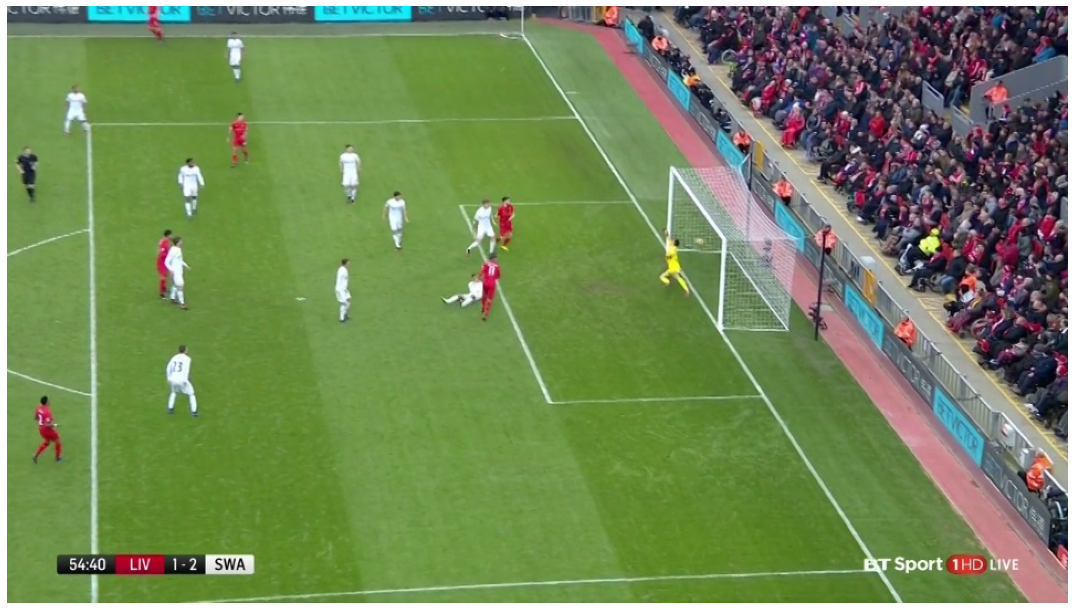

In [199]:
test_image_index = '00516'
test_image_path = f'{SN_CALI_DIR}/test/{test_image_index}.jpg'
test_image_json = f'{SN_CALI_DIR}/test/{test_image_index}.json'

test_image = cv2.imread(test_image_path)
_imshow(test_image, figsize='auto')

with open(test_image_json, 'r') as fr:
    test_anno = json.load(fr)
test_anno.keys(), test_anno['Circle right']

[72, 34, 0, 0, 30, 73] [202, 213, 225, 329, 339, 351]


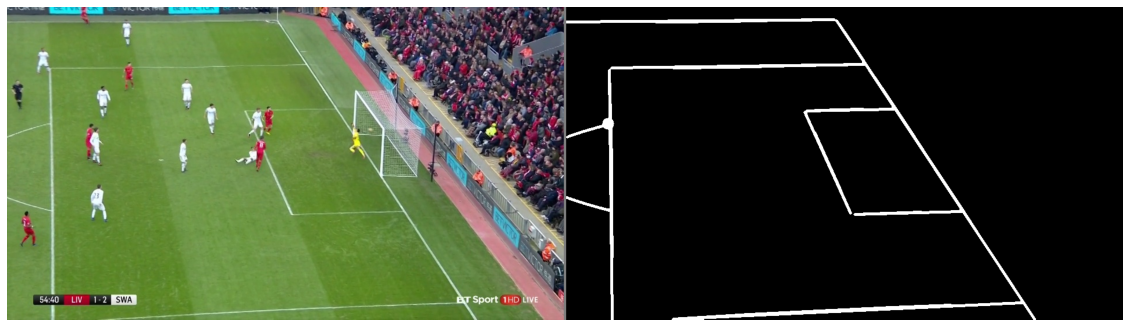

In [201]:
mask = np.zeros(test_image.shape[:-1] , dtype=np.uint8)

for lclass, points in test_anno.items():
    if lclass.startswith('Goal'):
        continue
    is_arc = False
    if lclass.startswith('Circle'):
        points = sorted(points, key=lambda item: item['y'])
        is_arc = True
        
    prev_point = None
    x_data, y_data = [], []
    for i, point in enumerate(points):
        next_point = (int(point["x"] * mask.shape[1]), int(point["y"] * mask.shape[0]))
        if is_arc:
            # print(next_point[0], next_point[1])
            x_data.append(next_point[0])
            y_data.append(next_point[1])
            if i == 0:
                cv2.circle(mask, next_point, 10, color=(255,), thickness=-1)
        else:
            if i > 0:
                cv2.line(mask, prev_point, next_point, (255,), 3)
            prev_point = next_point
    if len(y_data) > 0:
        print(x_data, y_data)
        # params, covariance = curve_fit(quadratic_function, y_data, x_data, method='lm')
        # a, b, c = params
        # x_fit = np.linspace(min(y_data), max(x_data), 300)
        # y_fit = quadratic_function(x_fit, a, b, c)
        # for x, y in zip(x_fit, y_fit):
        #     cv2.circle(mask, (int(y), int(x)), 2, color=(255,), thickness=1)
        
        y_data = [72, 34, 0]
        x_data = [202, 213, 225]
        params, covariance = curve_fit(quadratic_function, x_data, y_data, method='lm')
        x_fit = np.linspace(min(x_data), max(x_data), 100)
        y_fit = quadratic_function(x_fit, a, b, c)
        for x, y in zip(x_fit, y_fit):
            cv2.circle(mask, (int(y), int(x)), 2, color=(255,), thickness=1)
            
        y_data = [0, 30, 73]
        x_data = [329, 339, 351]
        params, covariance = curve_fit(quadratic_function, x_data, y_data, method='lm')
        a, b, c = params
        x_fit = np.linspace(min(x_data), max(x_data), 100)
        y_fit = quadratic_function(x_fit, a, b, c)
        for x, y in zip(x_fit, y_fit):
            cv2.circle(mask, (int(y), int(x)), 2, color=(255,), thickness=1)

    
kernel = np.ones((3, 3), np.uint8)
mask_closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
_imshow(_imgrid([test_image, mask_closing]), figsize=(20, 10))

In [196]:
quadratic_function(np.array([185]), a, b, c)

array([359.627555])

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


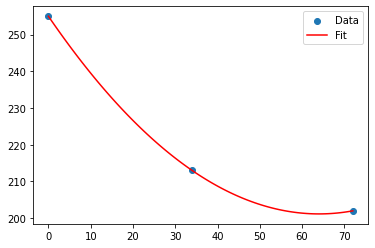

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 定义要拟合的函数，这里使用二次多项式作为例子
def quadratic_function(x, a, b, c):
    return a * x**2 + b * x + c

# 输入你的数据点
x_data = np.array([72, 34, 0])
y_data = np.array([202, 213, 255])

# 使用curve_fit进行曲线拟合
params, covariance = curve_fit(quadratic_function, x_data, y_data, method='lm')

# 获取拟合后的参数
a, b, c = params

# 生成拟合后的曲线
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = quadratic_function(x_fit, a, b, c)

# 绘制原始数据和拟合曲线
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_fit, y_fit, label='Fit', color='red')
plt.legend()
plt.show()

In [95]:
test_anno

{'Goal right crossbar': [{'x': 0.6302304800991272, 'y': 0.27932261108995593},
  {'x': 0.6727294000061899, 'y': 0.3822066236348395}],
 'Side line top': [{'x': 0.001460007243440268, 'y': 0.05052998953725295},
  {'x': 0.48224298531520304, 'y': 0.04430119356901053},
  {'x': 0.1613219211737545, 'y': 0.05022041754932529},
  {'x': 0.313135044486972, 'y': 0.04956644212237086}],
 'Goal right post right': [{'x': 0.6723452368170034, 'y': 0.5171841049465151},
  {'x': 0.6757064869252685, 'y': 0.4035650236527568}],
 'Big rect. right bottom': [{'x': 0.8167481884172578, 'y': 0.9456776704715879},
  {'x': 0.19229536188112892, 'y': 0.9978057624777943},
  {'x': 0.32878992706285476, 'y': 0.9831911153729626},
  {'x': 0.4549261232699743, 'y': 0.9707780009162125},
  {'x': 0.5845766282443647, 'y': 0.9601496605440183},
  {'x': 0.6911974739668914, 'y': 0.9536452451909362}],
 'Goal right post left': [{'x': 0.6262078698895565, 'y': 0.28713175518686046},
  {'x': 0.6242149395794148, 'y': 0.37001997430146744}],
 'Big

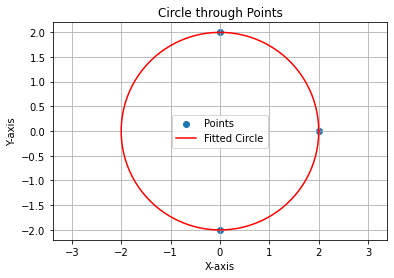

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

def circle_loss(params, points):
    center_x, center_y, radius = params
    distances = np.linalg.norm(points - np.array([center_x, center_y]), axis=1)
    return np.sum((distances - radius)**2)

def fit_circle(points):
    result = minimize(circle_loss, x0=[0, 0, 1], args=(points,), method='Nelder-Mead')
    center_x, center_y, radius = result.x
    return center_x, center_y, radius

def plot_circle_through_points(points):
    center_x, center_y, radius = fit_circle(points)

    theta = np.linspace(0, 2*np.pi, 100)
    circle_x = center_x + radius * np.cos(theta)
    circle_y = center_y + radius * np.sin(theta)

    plt.scatter(points[:, 0], points[:, 1], label='Points')
    plt.plot(circle_x, circle_y, label='Fitted Circle', color='red')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Circle through Points')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# 输入一组点的坐标和圆的半径
# points = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
points = np.array([[0, 2], [2, 0], [0, -2]])

# 绘制圆弧
plot_circle_through_points(points)

## References

- https://www.soccer-net.org/
- https://github.com/mazatov/sn-calibration
- [sn-calibration dataset camera][1]

[1]: https://github.com/SoccerNet/sn-calibration/issues/23